# Configuration model

In [1]:
import networkx as nx
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
from itertools import chain 
from itertools import zip_longest

## Parameters

The algorithm has 2 input parameters: 
* N: number of nodes
* p_k : nodes degree distribution

Insert the parameters of the algorithm (need to add the checks!!!!!!!!!)

### Size of the network

In [2]:
# Insert Number of Nodes
N = int(input("Insert number of nodes:\n"))

Insert number of nodes:
1000


### Distribution choice
Choose between a Poisson degree distribution (---> generates a ER network) and with a Powerlaw degreedistribution (---> generates a SF network)

In [3]:
p_k = int(input("Insert the probability distribution:\n--> type 1 for poisson\n--> type 2 for powerlaw\n"))

if p_k not in [1, 2]:
    raise ValueError("Incorrect number!")

Insert the probability distribution:
--> type 1 for poisson
--> type 2 for powerlaw
2


Insert distribution parameter

In [4]:
if p_k== 1:
    lamb = float(input("Insert lambda parameter:\n"))
else:
    gamma = float(input("Insert gamma parameter:\n"))

Insert gamma parameter:
2.2


In [5]:
sequence = [1]

# The degree sequence needs to have an even sum
while sum(sequence) % 2 != 0:
    sequence = []
    
    # Poisson distribution
    if p_k== 1:
        sequence = np.random.poisson(lamb, N)
         
    # Powerlaw distribution
    if p_k == 2:
        
        # Limit the number of self-loops and multiple edges in case of gamma between 2 and 3
        if gamma >= 2 and gamma <=3: 
            k_max = round(math.sqrt(N))
            
            for i in range(N):
                prob = float(nx.utils.powerlaw_sequence(n = 1,exponent=gamma)[0])
                deg = int(round(prob))
                while deg > k_max:
                    prob = float(nx.utils.powerlaw_sequence(1,exponent=gamma)[0])
                    deg = int(round(prob))
                sequence.append(deg)
        else:         
            seq=nx.utils.powerlaw_sequence(N,exponent=gamma)
            # round to integer values in the range [0,N]
            sequence = [min(N, max( int(round(s)),0 )) for s in seq]

      
print("Lenght of the sequence: {}".format(len(sequence)))
print("\nSequence of node degrees:\n {}".format(sequence))

Lenght of the sequence: 1000

Sequence of node degrees:
 [10, 2, 18, 1, 7, 1, 2, 1, 6, 6, 1, 4, 7, 1, 1, 2, 1, 2, 2, 1, 1, 1, 9, 2, 2, 2, 1, 2, 1, 2, 1, 5, 2, 22, 6, 1, 3, 1, 2, 3, 1, 3, 1, 2, 3, 5, 1, 4, 7, 1, 1, 2, 1, 2, 2, 2, 2, 5, 2, 5, 2, 1, 3, 5, 1, 1, 3, 2, 6, 1, 1, 1, 2, 4, 1, 2, 5, 8, 4, 1, 24, 1, 4, 5, 1, 1, 8, 1, 1, 7, 3, 1, 1, 5, 1, 2, 1, 3, 1, 1, 3, 1, 4, 4, 1, 2, 1, 1, 4, 3, 1, 3, 2, 2, 2, 1, 1, 4, 1, 3, 1, 2, 3, 3, 1, 2, 1, 1, 5, 22, 6, 4, 1, 1, 1, 4, 1, 1, 2, 1, 3, 8, 13, 4, 1, 4, 1, 3, 3, 1, 1, 2, 1, 3, 3, 2, 2, 1, 3, 2, 2, 1, 2, 3, 1, 1, 2, 2, 1, 3, 2, 7, 1, 1, 1, 4, 2, 3, 1, 3, 1, 2, 2, 1, 2, 2, 5, 4, 1, 1, 1, 5, 4, 2, 4, 1, 2, 5, 3, 3, 10, 4, 1, 2, 1, 4, 1, 3, 9, 1, 1, 2, 1, 7, 2, 1, 6, 1, 1, 2, 2, 6, 2, 2, 2, 11, 9, 1, 2, 1, 2, 2, 1, 5, 3, 1, 1, 1, 1, 4, 1, 2, 2, 6, 1, 1, 7, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 15, 1, 3, 8, 18, 2, 2, 3, 1, 2, 1, 7, 1, 1, 3, 1, 1, 2, 1, 1, 1, 2, 3, 1, 2, 2, 3, 2, 1, 3, 3, 8, 1, 1, 1, 2, 1, 20, 6, 1, 5, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1

## Algorithm
We need now to build a random graph/network with this degree sequence. <br>
Let's build before an empty graph of type MultiGraph, which allow self-loops and multiple edges

In [6]:
G = nx.empty_graph(N, create_using = nx.MultiGraph) # MultiGraph because of self-loops

Let's create the list of "stubs", i.e. a list of available degree-repeated nodes. 

In [7]:
#stubs_list = list(chain.from_iterable([n] * d for n, d in enumerate(sequence)))
stubs_list = []
for i in range(N):
    stubs_list += [i for _ in range(sequence[i])]

print(stubs_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 14, 15, 15, 16, 17, 17, 18, 18, 19, 20, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 24, 24, 25, 25, 26, 27, 27, 28, 29, 29, 30, 31, 31, 31, 31, 31, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 36, 36, 36, 37, 38, 38, 39, 39, 39, 40, 41, 41, 41, 42, 43, 43, 44, 44, 44, 45, 45, 45, 45, 45, 46, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 50, 51, 51, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 57, 57, 57, 58, 58, 59, 59, 59, 59, 59, 60, 60, 61, 62, 62, 62, 63, 63, 63, 63, 63, 64, 65, 66, 66, 66, 67, 67, 68, 68, 68, 68, 68, 68, 69, 70, 71, 72, 72, 73, 73, 73, 73, 74, 75, 75, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 8

Shuffle the slots list, i.e. perform a random permutation

In [8]:
np.random.shuffle(stubs_list)
stubs_list

[593,
 105,
 995,
 326,
 73,
 681,
 348,
 748,
 766,
 524,
 337,
 851,
 278,
 919,
 159,
 233,
 465,
 986,
 948,
 143,
 843,
 421,
 644,
 72,
 978,
 370,
 0,
 668,
 620,
 423,
 144,
 44,
 213,
 445,
 54,
 491,
 906,
 155,
 359,
 791,
 380,
 166,
 665,
 406,
 338,
 372,
 359,
 331,
 979,
 644,
 392,
 655,
 0,
 677,
 706,
 286,
 507,
 341,
 31,
 257,
 283,
 445,
 773,
 573,
 463,
 644,
 642,
 787,
 179,
 246,
 910,
 858,
 851,
 831,
 918,
 221,
 338,
 201,
 573,
 350,
 751,
 677,
 472,
 470,
 709,
 59,
 360,
 510,
 843,
 482,
 949,
 739,
 849,
 792,
 617,
 804,
 765,
 268,
 576,
 915,
 288,
 783,
 76,
 257,
 993,
 416,
 334,
 681,
 729,
 358,
 981,
 668,
 633,
 260,
 558,
 656,
 192,
 998,
 33,
 59,
 359,
 652,
 675,
 656,
 739,
 918,
 763,
 722,
 806,
 802,
 681,
 858,
 804,
 22,
 176,
 547,
 370,
 472,
 933,
 626,
 815,
 735,
 102,
 359,
 757,
 946,
 184,
 830,
 906,
 315,
 668,
 36,
 697,
 372,
 869,
 751,
 264,
 770,
 22,
 491,
 895,
 257,
 288,
 171,
 607,
 895,
 237,
 169,
 73,
 44

We can now bipartition the shuffled slot vector to have a random pairing of nodes. <br>
In that way we can use the add_edges_from function of networkx

In [9]:
#half = len(slots) // 2

#out_slots, in_slots = stubs_list[:half],stubs_list[half:]
#G.add_edges_from(zip(out_slots, in_slots)) # with zip we create a series of tuples from the 2 lists

Add edges between consecutive pairs of nodes in the shuffled stubs_list <br>
The main question is: <b>How to handle multiple edges and self-loops?

In [10]:
for i in range(0, len(stubs_list), 2):
    G.add_edge(stubs_list[i], stubs_list[i+1])

Let's check the presence of parallel edges

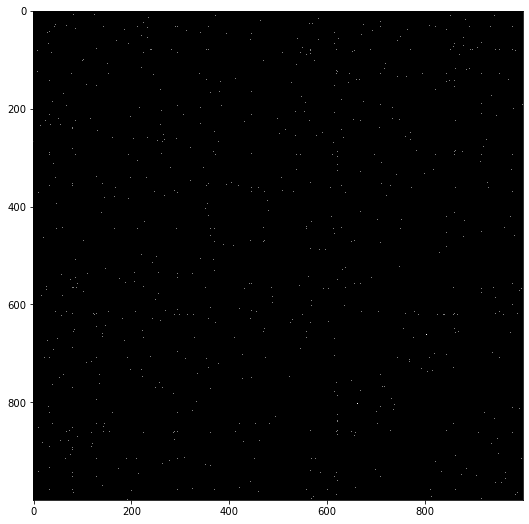

In [11]:
arr = nx.to_numpy_matrix(G)
plt.figure(figsize=(16,9))
plt.imshow(arr, interpolation='nearest', cmap='gray')
plt.show()

In [12]:
num_multiedges = np.sum(arr>=2) / 2 # divide by two as graph is undirected 
num_multiedges

10.0

Let's check the presence of self-loops

In [13]:
# number of self-loops
nx.number_of_selfloops(G)

4

In [14]:
# nodes with a self-loop
list(nx.nodes_with_selfloops(G))

[385, 406, 493, 804]

Remove parallel edges and selfloops

In [15]:
G = nx.Graph(G) # removes parallel edges
G.remove_edges_from(nx.selfloop_edges(G)) # removes selfloops

In [16]:
arr = nx.to_numpy_matrix(G)
num_multiedges = np.sum(arr>=2) / 2 # divide by two as graph is undirected 
num_multiedges

0.0

In [17]:
# number of self-loops
nx.number_of_selfloops(G)

0

### Save the network

In [18]:
nx.write_pajek(G, "test.net")
#nx.write_gexf(G, "test.gexf")

## Network descriptors

In [19]:
print("Number of nodes: {}".format(G.number_of_nodes()))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
if nx.is_connected(G):
    print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
    print("Diameter: {}".format(nx.diameter(G)))

Number of nodes: 1000
Number of edges: 1518
Min degree: 1
Max degree: 32
Avg degree: 3.036
Clustering: 0.0052
Assortativity: -0.0303


## Plots

### Plotting the network

In [20]:
#nx.draw(G, alpha = .3, edge_color = '#40a6d1', node_color = '#40a6d1', node_size=30, with_labels = True)

### Plotting the distribution

K_distr() function  for visualizing the distribution using linear or log-log scale.

Degree distribution of Barabási–Albert network is k**(-3) and so it gives a straight line in log-log scale.

In [21]:
# Plotting

def k_distrib(graph, scale='lin', colour='#40a6d1', alpha=.8, fit_line=False, expct_lo=1, expct_hi=10, expct_const=1):
    
    plt.close()
    num_nodes = graph.number_of_nodes()
    max_degree = 0
    
    # Calculate the maximum degree to know the range of x-axis
    for n in graph.nodes():
        if graph.degree(n) > max_degree:
            max_degree = graph.degree(n)
    
    # X-axis and y-axis values
    x = []
    y_tmp = []
    
    # Loop over all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree + 1):
        x.append(i)
        y_tmp.append(0)
        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp] 
    
    # Check for the lin / log parameter and set axes scale
    if scale == 'log':
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Degree distribution (log-log scale)')
        plt.ylabel('log(P(k))')
        plt.xlabel('log(k)')
        plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
        
        if fit_line:
            # Add theoretical distribution line k^-3
            # Note that you need to parametrize it manually
            w = [a for a in range(expct_lo,expct_hi)]
            z = []
            for i in w:
                x = (i**-3) * expct_const # set line's length and fit intercept
                z.append(x)

            plt.plot(w, z, 'k-', color='#7f7f7f')
            
    else:
        plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
        plt.title('Degree distribution (linear scale)')
        plt.ylabel('P(k)')
        plt.xlabel('k')

    plt.show()


* Linear scale example

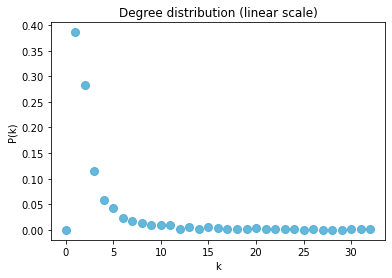

In [22]:
k_distrib(graph=G, colour='#40a6d1', alpha=.8)

* Log-log scale example

C:\Users\denal\AppData\Local\Temp/ipykernel_19188/1533974340.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(w, z, 'k-', color='#7f7f7f')


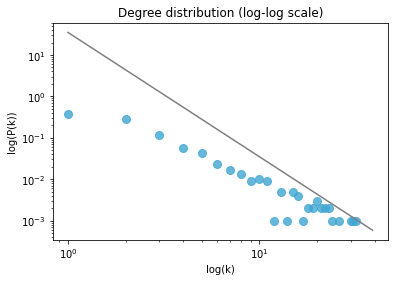

In [23]:
k_distrib(graph=G, colour='#40a6d1', scale='log', alpha=.8, fit_line=True, expct_lo=1, expct_hi=40, expct_const=35)

### Degree distribution plots

In [24]:
# Auxiliary function to create logaritmically spaced bins (for log-log histogram) by specifying the number of bins
def create_log_bins(degrees, num = 20):
    bins = np.logspace(np.log10(np.min(degrees)), np.log10(np.max(degrees)), num)
    bins = np.array(bins)
    return bins

In [25]:
# PDF histogram in linear scale
def plot_linear_PDF(G, name='', nbins = 15):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('PDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = False)
    plt.tight_layout()
    plt.style.use('ggplot')
        
#plot_linear_PDF(G)

In [26]:
# PDF histogram in Log-Log scale
def plot_loglog_PDF(G, name="", nbins=20):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num = nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('PDF in log-log scale',  fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = False)
    plt.tight_layout()
    #plt.style.use('ggplot')

#plot_loglog_PDF(G)

In [27]:
# CCDF histogram in linear scale
def plot_linear_CCDF(G, name="", nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('CCDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = -1)
    plt.tight_layout()
    #plt.style.use('ggplot')

#plot_linear_CCDF(G)

In [28]:
# CCDF histogram in Log-Log scale
def plot_loglog_CCDF(G, name="", nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num=nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('CCDF in log-log scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = -1)
    plt.tight_layout()
    #plt.style.use('ggplot')
    

#plot_loglog_CCDF(G)

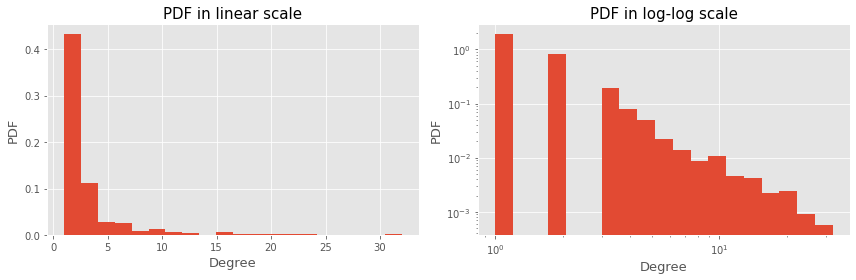

In [33]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_PDF(G, nbins=20) 
plt.subplot(1, 2, 2)
plot_loglog_PDF(G, nbins=20)
plt.show()

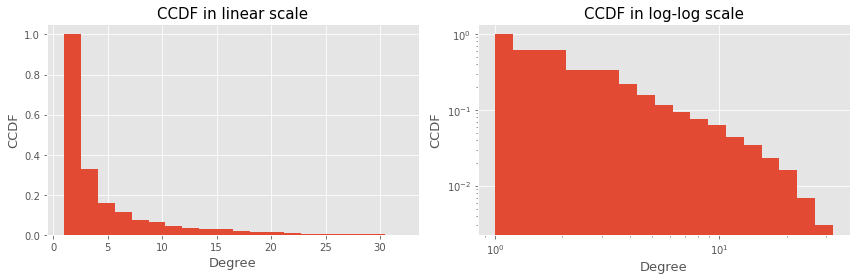

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_CCDF(G, nbins=20) 
plt.subplot(1, 2, 2)
plot_loglog_CCDF(G, nbins=20)
plt.show()

## Estimation of the exponent for the empirical degree distributions of BA and CM(SF), for the networks of size N>=1000.

We can use the powerlaw Python package described here: https://arxiv.org/abs/1305.0215, which is based on a MLE

In [31]:
#pip install powerlaw
#pip install mpmath 

In [32]:
import powerlaw
degrees = [G.degree(n) for n in G.nodes()]
results = powerlaw.Fit(degrees, discrete = True)
#results = powerlaw.Fit(degrees)
print("\n\nExponent estimation:")
print(round(results.power_law.alpha, 4))
#results.truncated_power_law.parameter1 # power law  parameter (alpha)
#results.truncated_power_law.parameter2 # exponential cut-off parameter (beta)
#print(results.power_law.xmin)

Calculating best minimal value for power law fit
xmin progress: 96%

Exponent estimation:
2.2566


### Using Linear Regression